# Sentence Embedding & K-Means

This notebook tries to use different pretrained sentence embeddings and unsupervised clustering algorithm to find meaningful clusters.

1. sentence embeddings
   - LaBSE
   - Mistral 7b instruct

 
2. clustering algorithm
   - K-Mean
   - DBSCAN

In [1]:
import preprocess
import numpy as np
import pandas as pd
import re
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import pairwise_distances
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

from tqdm.auto import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
import pickle

In [2]:
tqdm.pandas()

In [3]:
data = preprocess.read_encrypted_data()
df = preprocess.reformat_data(data)

In [4]:
dev_df = df.sample(random_state=0, frac=0.1)

In [5]:
# Call_Created_Date	
# Event_Anonymizer	
# Call_Class	
# Call_Subclass	
# Initial_Dispatched_Event_Type_Code_Desc	
# Initial_Dispatched_Subtype_Code_Desc	
# Initial_Dispatched_Priority	
# Public_Generated_Event_Flag	
# Event_Attended_Flag	
# Event_Type_Changed_Flag	
# Event_Subtype_Changed_Flag	
# Event_Priority_Changed_Flag	
# Grouped_Event_Type_Code_Desc	
# Grouped_Event_Subtype_Code_Desc	
# Priority

In [6]:

glossary = {
    "CO": "Complainant",
    "VI": "Victim",
    "VREG": "Vehicle Registration",
    "LRT": "Light Rail Transit", 
    #"Standby":	"Police presence requested to remove belongings from a location",
    "REG":	"Regimental number of officer",
    "UNIT":	"police vehicle unit",
    "BMQ":	"Broadcast Message Question (message broadcasted over the police radio instead of CAD to alert units)",
    "RTOC":	"Real Time Operations Centre",
    "CSS":	"Court Services Section",
    "ECO":	"Emergency Call Operator (call taker at 911)",
    "KOC":	"Knows of call (indicates Duty Sergeant (Sgt.) is aware of event)",
    "CST":	"Constable/Officer",
    "SENTRY": "The Police Records System",
    #"Event Priority":	'Level of response required (see "Data Column Summary" for a breakdown and definition)',
    "APU":	"Arrest Processing Unit",
    "EPO":	"Emergency Protection Order",
    #"dispatch cad code": "refers to event type code generated by call taking assistance tool. Dispatch CAD codes are mapped to our internal event subtypes (10 codes)",
    #"cross-referenced":	"some calls may be related, hence will be cross-referenced",
    "LOI": "Location of Interest",
    "DOAP":"Downtown Outreach Addictions Partnership run by Alpha House Society (nonprofit) (CPS partners with various nonprofit agencies providing service to people in need)",
    "POET":"Prolific Offender Engagement Team",
    "BWC":"Body Worn Camera"
}


# Expand acronyms in a text
def hybrid_expand_acronyms(text, glossary=glossary):
    for acronym, full_term in glossary.items():
        # Use word boundaries to replace only whole words
        text = re.sub(rf'\b{acronym}\b', f'{acronym} ({full_term})', text)
    return text


# Function to compile text from the dataframe row
def compile_text(x):
    text = (
        f"Description of the behaviour or criminal offense (Occurrence_Type): {x['Occurrence_Type']} " 
        f"Broadest level categorization of Occurrence_Type: {x['Occurrence_Type_UCR_Category']} " 
        f"Second level categorization of Occurrence_Type: {x['Occurrence_Report_Category']} "
        f"The priority level assigned to the call by the ECO (911 call taker): {x['Priority']} "
        f"The call was initiated by a member of the public: {x['Public_Generated_Event_Flag']} " 
        f"Flag that indicates the call was attended in person by an officer: {x['Event_Attended_Flag']} "
        f"The log of the event: {hybrid_expand_acronyms(x['Event_Remarks_Text'])}" 
    )
    text = re.sub(r"\[redacted\]", "[MASK]", text, flags=re.IGNORECASE)
    return text


# Function to output embeddings
def output_embedding(txt, model):
    try:
        embd = model.encode(txt, device="mps")
        return embd
    except Exception as e:
        print(f"Error encoding text: {e}")
        return None


In [7]:
# Load sentence transformers
LaBSE_model = SentenceTransformer("sentence-transformers/LaBSE")
embeddings = LaBSE_model.encode(['I want to have some chinese food.', 'I love Japanese food.'])
embeddings.shape

(2, 768)

In [8]:
# Apply the preprocessing function to the dataframe
df['LaBSE_text_embedding'] = df.progress_apply(lambda x: output_embedding(compile_text(x), LaBSE_model), axis=1)


# Convert the embeddings to a suitable format for clustering
embeddings = df['LaBSE_text_embedding'].tolist()

embeddings_array = np.array(embeddings)

# Use KMeans with cosine distance
kmeans = KMeans(n_clusters=30, random_state=0)

# KMeans doesn't directly support cosine similarity, so we convert cosine distance to euclidean distance
cosine_sim_matrix = 1 - pairwise_distances(embeddings_array, metric='cosine')
kmeans.fit(cosine_sim_matrix)

# Assign clusters back to the dataframe
df['LaBSE_cluster'] = kmeans.labels_

print(df[['LaBSE_text_embedding', 'LaBSE_cluster']])

  0%|          | 0/9751 [00:00<?, ?it/s]

/Users/haydenchiu/miniconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


                                   LaBSE_text_embedding  LaBSE_cluster
0     [0.0076662553, -0.020088516, -0.024753636, 0.0...             25
1     [0.02313869, -0.006847671, -0.0057531293, 0.03...             27
2     [-0.022099957, -0.034860756, -0.026870131, -0....              7
3     [-0.027315184, -0.0034824924, -0.0190649, -0.0...             28
4     [-0.017639345, -0.010309014, -0.0080814455, 0....             23
...                                                 ...            ...
9746  [-0.016840262, -0.02387571, -0.037669063, 0.00...              4
9747  [-0.023106728, -0.051744323, -0.01550566, 0.00...             10
9748  [-0.03080329, -0.01818838, -0.023323227, 0.026...             28
9749  [-0.030331405, -0.018865721, -0.03180085, 0.04...             13
9750  [-0.016345901, -0.03509963, -0.00984825, 0.000...             28

[9751 rows x 2 columns]


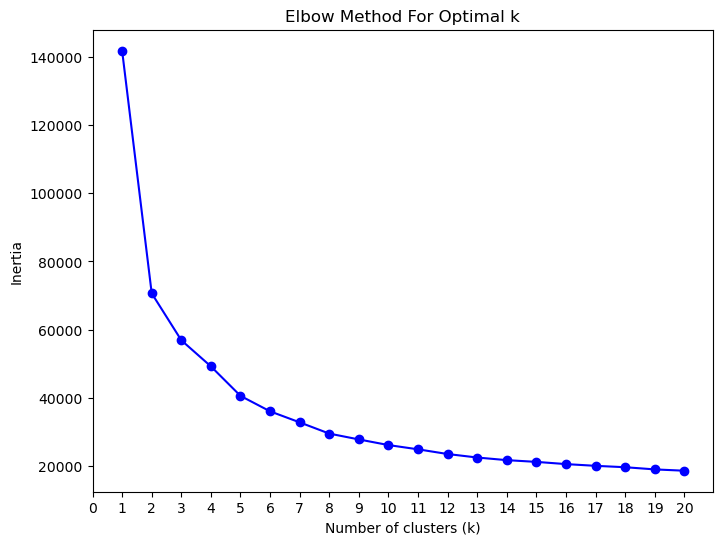

In [9]:
# Elbow method to find the optimal number of clusters
inertia = []
K = range(1, 21)

for k in K:
    kmeans = KMeans(n_clusters=k, n_init="auto", random_state=0)
    # KMeans doesn't directly support cosine similarity, so we convert cosine distance to euclidean distance
    cosine_sim_matrix = 1 - pairwise_distances(embeddings_array, metric='cosine')
    kmeans.fit(cosine_sim_matrix)
    inertia.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(8, 6))
plt.plot(K, inertia, 'bo-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
plt.xticks(np.arange(0, 21, step=1))
plt.show()

# Let's say we have 9 clusters

In [10]:
kmeans = KMeans(n_clusters=9, random_state=0)

kmeans.fit(cosine_sim_matrix)

# Assign clusters back to the dataframe
df['LaBSE_cluster'] = kmeans.labels_

print(df[['Event_Remarks_Text', 'LaBSE_cluster']])

/Users/haydenchiu/miniconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


                                     Event_Remarks_Text  LaBSE_cluster
0                    WALKTHRU\nSPECIAL ADDRESS COMMENT:              1
1     WALKTHRU\n1825 [Redacted]\n1458 IT; ADULT FML ...              6
2     [Redacted] WIR\n[Redacted] SITE W5426\n4637 [R...              0
3     [Redacted] MOB H\nAccept Advised Event:\nSPECI...              5
4     [Redacted] MOBIL\nProblem: OUTSIDE OF [Redacte...              2
...                                                 ...            ...
9746  CO SECURITY REPORTING A 1041 ON NON EMERG BUT ...              7
9747  FAMILY MEMBER HAS PASSED, ALL THE PAPERWORK WI...              7
9748  FREEDOM [Redacted]\nAccept Advised Event:\n[Re...              0
9749  P915 (CAD) NO TIMERS, TAKING LRT THROUGHOUT 3,...              4
9750  CO SAID HER SON WENT OUT AROUND 2100 HRS, 2023...              0

[9751 rows x 2 columns]


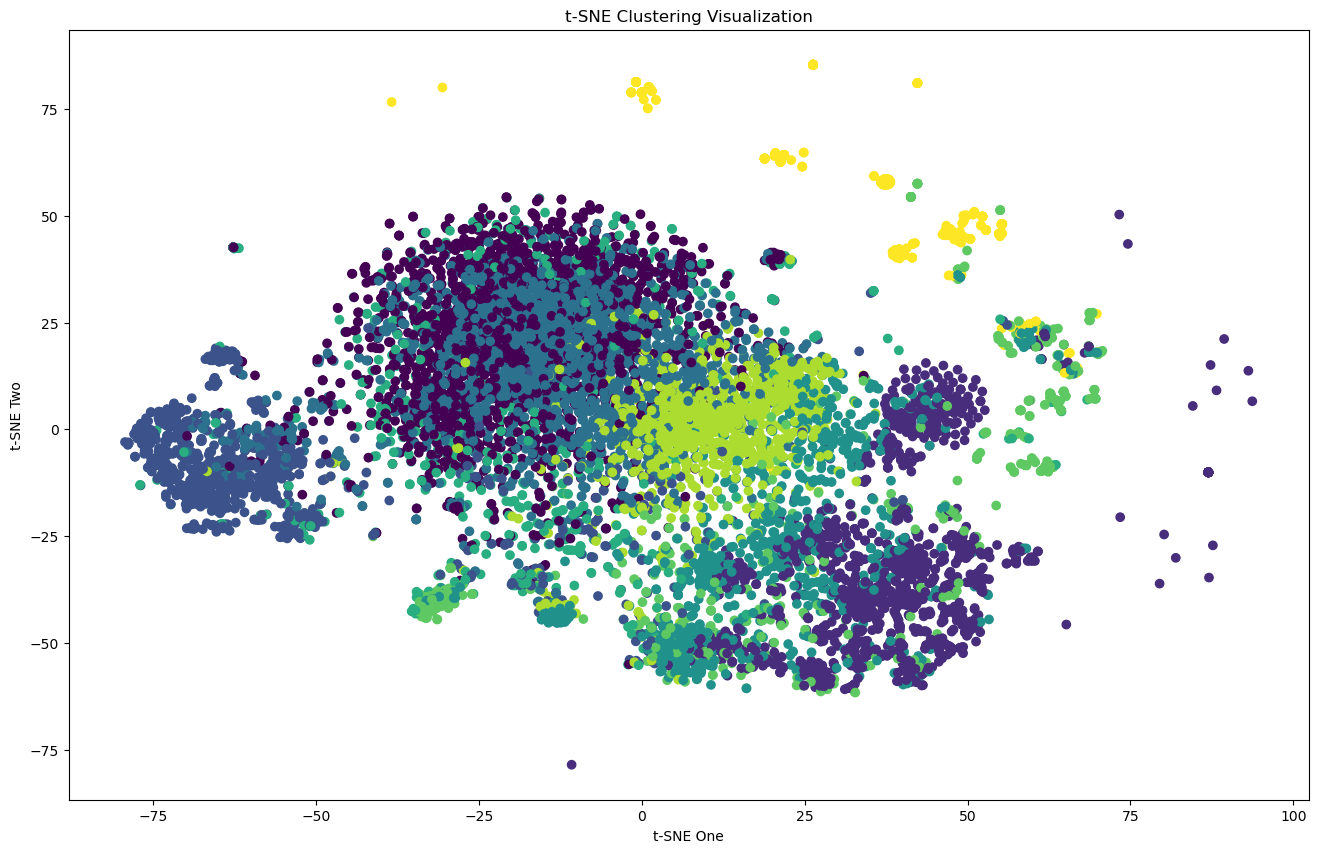

In [11]:
# Visualization using t-SNE
tsne = TSNE(n_components=2, random_state=0)
tsne_result = tsne.fit_transform(embeddings_array)
df['tsne-one'] = tsne_result[:,0]
df['tsne-two'] = tsne_result[:,1]

plt.figure(figsize=(16,10))
plt.scatter(df['tsne-one'], df['tsne-two'], c=df['LaBSE_cluster'], cmap='viridis')
plt.xlabel('t-SNE One')
plt.ylabel('t-SNE Two')
plt.title('t-SNE Clustering Visualization')
plt.show()

# Let's try another embedding

In [17]:
mistral_model = SentenceTransformer("intfloat/e5-mistral-7b-instruct")
mistral_model.max_seq_length = 4096

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [18]:
# My computer runs out of memory if I encode the compiled text column in one go
def dataframe_chunk_generator(dataframe, chunk_size):
    # Calculate the number of chunks
    num_chunks = np.ceil(len(dataframe) / chunk_size).astype(int)
    # Split the DataFrame into chunks
    chunks = np.array_split(dataframe, num_chunks)
    # Yield each chunk one by one
    for chunk in chunks:
        yield chunk

In [19]:
chunk_size = 500  # Define the size of each chunk

# Create the generator
chunk_gen = dataframe_chunk_generator(df, chunk_size)

# Get the number of chunks
num_chunks = np.ceil(len(df) / chunk_size).astype(int)

# Embeddings save to PATH
SAVE_2_PATH = "data/embeddings/mistral_7b_instruct/"

# Process each chunk
# only need to run this once **************

# for i, chunk in enumerate(tqdm(chunk_gen, total=num_chunks)):
#     chunk['mistral_text_embedding'] = chunk.progress_apply(lambda x: output_embedding(compile_text(x), mistral_model), axis=1)

#     embeddings = chunk["mistral_text_embedding"].tolist()
#     id = chunk["Event_Anonymizer"].tolist()

#     # dump to .pkl to save RAM for computation
#     with open(SAVE_2_PATH + f"embeddings_{i}.pkl", "wb") as fOut:
#         pickle.dump({"Event_Anonymizer": id, "embeddings": embeddings}, fOut, protocol=pickle.HIGHEST_PROTOCOL)
        
#*******************************************


In [20]:
# Initialize an empty list to store DataFrames
df_list = []

# Load sentences & embeddings from disk and create DataFrames
for i in range(num_chunks):
    with open(SAVE_2_PATH + f"embeddings_{i}.pkl", "rb") as fIn:
        stored_data = pickle.load(fIn)
        stored_id = stored_data["Event_Anonymizer"]
        stored_embeddings = stored_data["embeddings"]
        
        # Create a DataFrame for the current chunk
        chunk_df = pd.DataFrame({
            "Event_Anonymizer": stored_id,
            "Embeddings": stored_embeddings
        })
        
        # Append the chunk DataFrame to the list
        df_list.append(chunk_df)

# Concatenate all chunk DataFrames into a single DataFrame
embed_df = pd.concat(df_list, ignore_index=True)

# Display the final DataFrame
display(embed_df)

,Event_Anonymizer,Embeddings
0,202423001278,"[0.0034871278, -0.010431949, 0.014551269, 0.00..."
1,202423001280,"[0.0057456694, -0.0104579115, 0.020169267, 0.0..."
2,202423001325,"[0.0065838792, 0.0025630738, 0.009482914, -0.0..."
3,202423001351,"[0.007507125, -0.0034694492, 0.017589558, -0.0..."
4,202423001358,"[0.013097482, -0.0039111213, 0.021569282, -0.0..."
...,...,...
9746,202423132445,"[0.006924143, -0.0071287937, 0.021475859, 0.00..."
9747,202423132485,"[0.00756824, -0.011262343, 0.018168962, 0.0021..."
9748,202423132486,"[0.012483869, -0.0049044103, 0.018635146, -0.0..."
9749,202423132493,"[0.0071418197, -0.0042587672, 0.018737456, -0...."


In [22]:
df = df.merge(embed_df,how="left",on="Event_Anonymizer")

,Event_Anonymizer,Grouped_Event_Type_Code_Desc,Grouped_Event_Subtype_Code_Desc,Occurrence_Type,Occurrence_Type_UCR_Category,Occurrence_Report_Category,Priority,Public_Generated_Event_Flag,Event_Attended_Flag,Event_Remarks_Text,LaBSE_text_embedding,LaBSE_cluster,tsne-one,tsne-two,Embeddings
0,202423001278,MISCELLANEOUS,X99 MISCELLANEOUS,NONE,NONE,NONE,3,False,True,WALKTHRU\nSPECIAL ADDRESS COMMENT:,"[0.0076662553, -0.020088516, -0.024753636, 0.0...",1,28.919374,-31.826899,"[0.0034871278, -0.010431949, 0.014551269, 0.00..."
1,202423001280,MISCELLANEOUS,X99 MISCELLANEOUS,NONE,NONE,NONE,3,False,True,WALKTHRU\n1825 [Redacted]\n1458 IT; ADULT FML ...,"[0.02313869, -0.006847671, -0.0057531293, 0.03...",6,29.465776,-59.569233,"[0.0057456694, -0.0104579115, 0.020169267, 0.0..."
2,202423001325,MISCELLANEOUS,X99 MISCELLANEOUS,NONE,NONE,NONE,3,True,False,[Redacted] WIR\n[Redacted] SITE W5426\n4637 [R...,"[-0.022099957, -0.034860756, -0.026870131, -0....",0,-33.734329,-4.256087,"[0.0065838792, 0.0025630738, 0.009482914, -0.0..."
3,202423001351,MISCELLANEOUS,X99 MISCELLANEOUS,NONE,NONE,NONE,3,True,False,[Redacted] MOB H\nAccept Advised Event:\nSPECI...,"[-0.027315184, -0.0034824924, -0.0190649, -0.0...",5,-38.623272,-2.859020,"[0.007507125, -0.0034694492, 0.017589558, -0.0..."
4,202423001358,MISCELLANEOUS,X99 MISCELLANEOUS,NONE,NONE,NONE,2,True,True,[Redacted] MOBIL\nProblem: OUTSIDE OF [Redacte...,"[-0.017639345, -0.010309014, -0.0080814455, 0....",2,-63.636555,-22.396582,"[0.013097482, -0.0039111213, 0.021569282, -0.0..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9746,202423132445,MISCELLANEOUS,X99 MISCELLANEOUS,NONE,NONE,NONE,3,True,False,CO SECURITY REPORTING A 1041 ON NON EMERG BUT ...,"[-0.016840262, -0.02387571, -0.037669063, 0.00...",7,10.115221,-11.436321,"[0.006924143, -0.0071287937, 0.021475859, 0.00..."
9747,202423132485,MISCELLANEOUS,X99 MISCELLANEOUS,NONE,NONE,NONE,3,True,False,"FAMILY MEMBER HAS PASSED, ALL THE PAPERWORK WI...","[-0.023106728, -0.051744323, -0.01550566, 0.00...",7,2.611074,6.745761,"[0.00756824, -0.011262343, 0.018168962, 0.0021..."
9748,202423132486,MISCELLANEOUS,X99 MISCELLANEOUS,NONE,NONE,NONE,3,True,False,FREEDOM [Redacted]\nAccept Advised Event:\n[Re...,"[-0.03080329, -0.01818838, -0.023323227, 0.026...",0,19.719963,39.701141,"[0.012483869, -0.0049044103, 0.018635146, -0.0..."
9749,202423132493,MISCELLANEOUS,X99 MISCELLANEOUS,NONE,NONE,NONE,3,False,True,"P915 (CAD) NO TIMERS, TAKING LRT THROUGHOUT 3,...","[-0.030331405, -0.018865721, -0.03180085, 0.04...",4,17.097752,-42.967056,"[0.0071418197, -0.0042587672, 0.018737456, -0...."


In [25]:
# Apply the preprocessing function to the dataframe
# df['mistral_text_embedding'] = df.progress_apply(lambda x: output_embedding(compile_text(x), mistral_model), axis=1)

# Convert the embeddings to a suitable format for clustering
embeddings = df['Embeddings'].tolist()

embeddings_array = np.array(embeddings)

# Use KMeans with cosine distance
kmeans = KMeans(n_clusters=9, random_state=0)

# KMeans doesn't directly support cosine similarity, so we convert cosine distance to euclidean distance
cosine_sim_matrix = 1 - pairwise_distances(embeddings_array, metric='cosine')
kmeans.fit(cosine_sim_matrix)

# Assign clusters back to the dataframe
df['mistral_cluster'] = kmeans.labels_

print(df[['Embeddings', 'mistral_cluster']])

/Users/haydenchiu/miniconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


                                             Embeddings  mistral_cluster
0     [0.0034871278, -0.010431949, 0.014551269, 0.00...                4
1     [0.0057456694, -0.0104579115, 0.020169267, 0.0...                4
2     [0.0065838792, 0.0025630738, 0.009482914, -0.0...                8
3     [0.007507125, -0.0034694492, 0.017589558, -0.0...                8
4     [0.013097482, -0.0039111213, 0.021569282, -0.0...                8
...                                                 ...              ...
9746  [0.006924143, -0.0071287937, 0.021475859, 0.00...                4
9747  [0.00756824, -0.011262343, 0.018168962, 0.0021...                6
9748  [0.012483869, -0.0049044103, 0.018635146, -0.0...                8
9749  [0.0071418197, -0.0042587672, 0.018737456, -0....                6
9750  [0.009521906, -0.010803062, 0.022279844, 0.008...                2

[9751 rows x 2 columns]


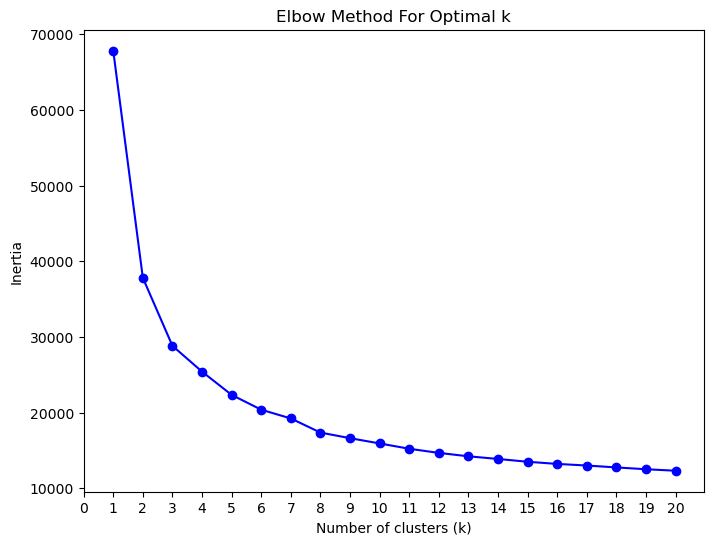

In [26]:
# Elbow method to find the optimal number of clusters
inertia = []
K = range(1, 21)

for k in K:
    kmeans = KMeans(n_clusters=k, n_init="auto", random_state=0)
    # KMeans doesn't directly support cosine similarity, so we convert cosine distance to euclidean distance
    cosine_sim_matrix = 1 - pairwise_distances(embeddings_array, metric='cosine')
    kmeans.fit(cosine_sim_matrix)
    inertia.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(8, 6))
plt.plot(K, inertia, 'bo-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
plt.xticks(np.arange(0, 21, step=1))
plt.show()

In [27]:
kmeans = KMeans(n_clusters=9, random_state=0)

kmeans.fit(cosine_sim_matrix)

# Assign clusters back to the dataframe
df['mistral_cluster'] = kmeans.labels_

print(df[['Event_Remarks_Text', 'mistral_cluster']])

/Users/haydenchiu/miniconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


                                     Event_Remarks_Text  mistral_cluster
0                    WALKTHRU\nSPECIAL ADDRESS COMMENT:                4
1     WALKTHRU\n1825 [Redacted]\n1458 IT; ADULT FML ...                4
2     [Redacted] WIR\n[Redacted] SITE W5426\n4637 [R...                8
3     [Redacted] MOB H\nAccept Advised Event:\nSPECI...                8
4     [Redacted] MOBIL\nProblem: OUTSIDE OF [Redacte...                8
...                                                 ...              ...
9746  CO SECURITY REPORTING A 1041 ON NON EMERG BUT ...                4
9747  FAMILY MEMBER HAS PASSED, ALL THE PAPERWORK WI...                6
9748  FREEDOM [Redacted]\nAccept Advised Event:\n[Re...                8
9749  P915 (CAD) NO TIMERS, TAKING LRT THROUGHOUT 3,...                6
9750  CO SAID HER SON WENT OUT AROUND 2100 HRS, 2023...                2

[9751 rows x 2 columns]


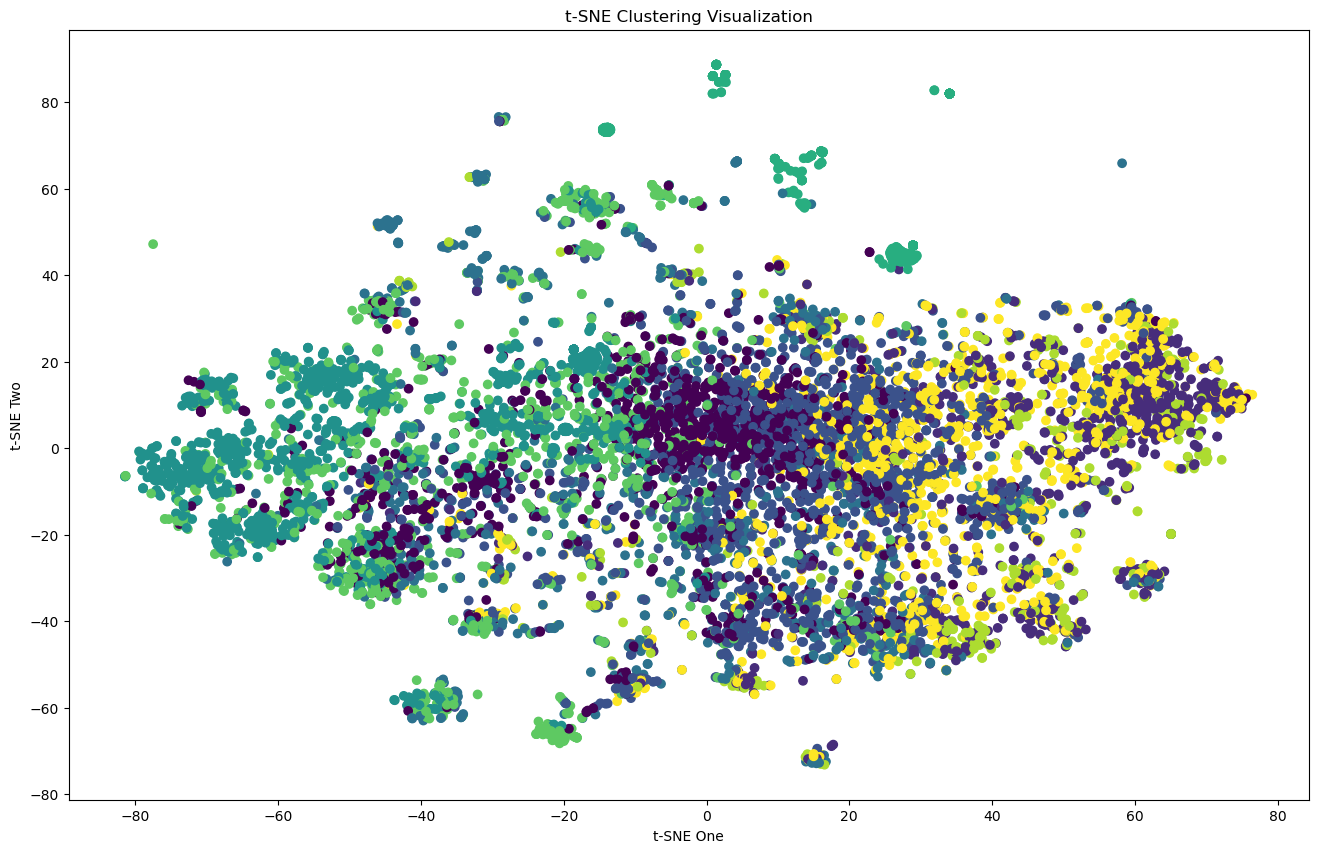

In [28]:
# Visualization using t-SNE
tsne = TSNE(n_components=2, random_state=0)
tsne_result = tsne.fit_transform(embeddings_array)
df['tsne-one'] = tsne_result[:,0]
df['tsne-two'] = tsne_result[:,1]

plt.figure(figsize=(16,10))
plt.scatter(df['tsne-one'], df['tsne-two'], c=df['mistral_cluster'], cmap='viridis')
plt.xlabel('t-SNE One')
plt.ylabel('t-SNE Two')
plt.title('t-SNE Clustering Visualization')
plt.show()

# Finding Meaningful Clusters
using tfidf by clusters

In [29]:
def extract_key_phrases(data, text_column, cluster_column, ngram_range=(1, 4), stop_words='english', min_df=2, max_df=0.8, top_n=10):
    
    df = data.copy()
    # remove [redacted]
    df[text_column] = df[text_column].apply(lambda x: re.sub(r"\[redacted\]", "", x, flags=re.IGNORECASE))
        
    # Group text by the specified cluster column
    grouped_txt = df.groupby(cluster_column)[text_column].apply(' '.join).reset_index()
    
    # Initialize TF-IDF Vectorizer
    tfidf_vectorizer = TfidfVectorizer(ngram_range=ngram_range, stop_words=stop_words, min_df=min_df, max_df=max_df)
    
    # Fit and transform the text data
    tfidf_matrix = tfidf_vectorizer.fit_transform(grouped_txt[text_column])
    
    # Extract feature names and TF-IDF scores
    feature_names = tfidf_vectorizer.get_feature_names_out()
    tfidf_scores = tfidf_matrix.toarray()
    
    # Extract key phrases for each group
    key_phrases = {}
    for i, group in enumerate(grouped_txt[cluster_column]):
        scores = tfidf_scores[i]
        sorted_indices = scores.argsort()[::-1]
        top_n_indices = sorted_indices[:top_n]
        key_phrases[group] = [feature_names[idx] for idx in top_n_indices]
    
    # Print key phrases for each group
    for group, phrases in key_phrases.items():
        print(f"Group {group}:")
        print(", ".join(phrases))
    
    return key_phrases


In [30]:
extract_key_phrases(df, "Event_Remarks_Text", "LaBSE_cluster")

Group 0:
says, eco, said, wants, incident, person, know, stated, asked, like
Group 1:
timers accept, timers accept advised event, timers accept advised, backup timers, timers special address comment, timers special address, timers special, subpoena, timers backup, timers timers
Group 2:
incident, caller scene, person, known, determinant, determinant level, dispatch cad code, cad code, dispatch cad, chief
Group 3:
eco, said, says, incident, wants, asked, person, know, stated, line
Group 4:
special address comment announced, comment announced, address comment announced, practice lockdown, announced practice, address comment announced practice, comment announced practice, announced practice lockdown, backup timers, comment announced practice lockdown
Group 5:
h2, tc20, says, nb, incident, sb, said, 2902, person, eb
Group 6:
access area, type changed dispatch_codes, changed dispatch_codes, event type changed dispatch_codes, type changed dispatch_codes subject_stop, subject_stop, dispatch_c

{0: ['says',
  'eco',
  'said',
  'wants',
  'incident',
  'person',
  'know',
  'stated',
  'asked',
  'like'],
 1: ['timers accept',
  'timers accept advised event',
  'timers accept advised',
  'backup timers',
  'timers special address comment',
  'timers special address',
  'timers special',
  'subpoena',
  'timers backup',
  'timers timers'],
 2: ['incident',
  'caller scene',
  'person',
  'known',
  'determinant',
  'determinant level',
  'dispatch cad code',
  'cad code',
  'dispatch cad',
  'chief'],
 3: ['eco',
  'said',
  'says',
  'incident',
  'wants',
  'asked',
  'person',
  'know',
  'stated',
  'line'],
 4: ['special address comment announced',
  'comment announced',
  'address comment announced',
  'practice lockdown',
  'announced practice',
  'address comment announced practice',
  'comment announced practice',
  'announced practice lockdown',
  'backup timers',
  'comment announced practice lockdown'],
 5: ['h2',
  'tc20',
  'says',
  'nb',
  'incident',
  'sb',
 

In [31]:
extract_key_phrases(df, "Event_Remarks_Text", "mistral_cluster")

Group 0:
advised event comments, accept advised event comments, event comments, asking, friend, wir, provide, saying, 211, assistance
Group 1:
caller scene, involved, determinant, determinant level, known, cad code, dispatch cad, dispatch cad code, disturbance, chief
Group 2:
saying, caller scene, asking, states, involved, landlord, son, problem, chief, urgent
Group 3:
caller scene, urgent, 311, mb24, problem, urgent request, non urgent, chief, saying, non urgent request
Group 4:
timers accept, timers accept advised, timers accept advised event, backup timers, timers special address, timers special, timers special address comment, bu timers, timers backup, lockdown
Group 5:
removed accept, removed accept advised event, removed accept advised, area epo, access area epo, allow access area epo, bond removed accept, peace bond removed accept, peace bond removed, bond removed
Group 6:
lockdown, practice lockdown, announced, practice, comment announced, special address comment announced, add

{0: ['advised event comments',
  'accept advised event comments',
  'event comments',
  'asking',
  'friend',
  'wir',
  'provide',
  'saying',
  '211',
  'assistance'],
 1: ['caller scene',
  'involved',
  'determinant',
  'determinant level',
  'known',
  'cad code',
  'dispatch cad',
  'dispatch cad code',
  'disturbance',
  'chief'],
 2: ['saying',
  'caller scene',
  'asking',
  'states',
  'involved',
  'landlord',
  'son',
  'problem',
  'chief',
  'urgent'],
 3: ['caller scene',
  'urgent',
  '311',
  'mb24',
  'problem',
  'urgent request',
  'non urgent',
  'chief',
  'saying',
  'non urgent request'],
 4: ['timers accept',
  'timers accept advised',
  'timers accept advised event',
  'backup timers',
  'timers special address',
  'timers special',
  'timers special address comment',
  'bu timers',
  'timers backup',
  'lockdown'],
 5: ['removed accept',
  'removed accept advised event',
  'removed accept advised',
  'area epo',
  'access area epo',
  'allow access area epo',

In [32]:
df.to_csv("data/sentence_embeddings_clustering.csv",index=False)